In [1]:
!pip install h5py

## Data

In [11]:
import h5py
import glob

path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
pace318_train = glob.glob(path + 'pace318_train_set/H5/*.h5')
pace318_test = glob.glob(path + 'pace318_test_set/H5/*.h5')

rowNum = 3

if pace318_train:
    with h5py.File(pace318_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 318\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
        print('\n\n')

else:
    print("File not found")

pace325_train = glob.glob(path + 'pace325_train_set/H5/*.h5')
pace325_test = glob.glob(path + 'pace325_test_set/H5/*.h5')

if pace325_train:
    with h5py.File(pace325_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 325\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
else:
    print("File not found")

Keys: ['geometry', 'inputs', 'outputs']
Pace 318

first_geometry shape:  (3,) first_geometry:  [0.08914796 0.16880947 0.10318343] 

first_input shape:  (11,) first_input:  [0.08572294 0.61110255 0.85597203 0.82917943 0.00633835 0.73598566
 0.30098127 0.25647371 0.17699116 0.09897413 0.00674982] 

first_output shape:  (22,) first_output:  [0.02365114 0.15301892 0.12525921 0.09508325 0.06724529 0.04895108
 0.02794279 0.02531836 0.01383378 0.0101849  0.00736416 0.56117202
 0.64358048 0.63291136 0.6215687  0.60499423 0.60844916 0.58988128
 0.5607913  0.51324512 0.48958556 0.47816882] 




Keys: ['geometry', 'inputs', 'outputs']
Pace 325

first_geometry shape:  (3,) first_geometry:  [0.43138777 0.04664672 0.18537623] 

first_input shape:  (14,) first_input:  [0.3338711  0.58466833 0.69590435 0.95397432 0.52926811 0.89549399
 0.72597417 0.74137618 0.19366376 0.40013094 0.98825008 0.07634631
 0.9805122  0.84911726] 

first_output shape:  (22,) first_output:  [0.03969655 0.09654982 0.08385258 

## Training loop: pace318_train input vs output

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data

import h5py
import glob

# Custom Dataset class
class H5Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    
    def __len__(self):
        # Assuming all files have the same number of rows for simplicity
        with h5py.File(self.file_paths[0], 'r') as file:
            return file['geometry'].shape[0]
    
    def __getitem__(self, idx):
        # Load data from the first file for simplicity (can extend this for multiple files)
        with h5py.File(self.file_paths[0], 'r') as file:
            input_data = file['inputs'][idx]
            output_data = file['outputs'][idx]
        
        # Convert numpy arrays to PyTorch tensors
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        
        return input_tensor, output_tensor

# Path to the .h5 files
path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
pace318_train = glob.glob(path + 'pace318_train_set/H5/chunk1.h5')

# Create the dataset and dataloader
train_data = H5Dataset(pace318_train)
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# Example: Iterate over the dataloader
for batch_idx, (inputs, outputs) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs: {inputs.shape}")
    print(f"Outputs: {outputs.shape}")
    break  # Just showing one batch as an example


Batch 1
Inputs: torch.Size([32, 11])
Outputs: torch.Size([32, 22])


In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(14, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 22)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression model (a simple feedforward network)
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model and move it to the GPU (if available)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model = RegressionModel(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Create the dataset and dataloader (assuming H5Dataset is defined elsewhere)
train_data = H5Dataset(pace318_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = H5Dataset(pace318_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Training loop
num_epochs = 3  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [17]:

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for inputs, targets in train_dataloader:
        # Move inputs and targets to the GPU (if available)
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'regression_model.pth')

print("Training complete and model saved.")


Epoch [1/3], Train Loss: 0.0208, Test Loss: 0.0278
Epoch [2/3], Train Loss: 0.0202, Test Loss: 0.0281
Epoch [3/3], Train Loss: 0.0195, Test Loss: 0.0287
Training complete and model saved.


In [18]:
import matplotlib.pyplot as plt

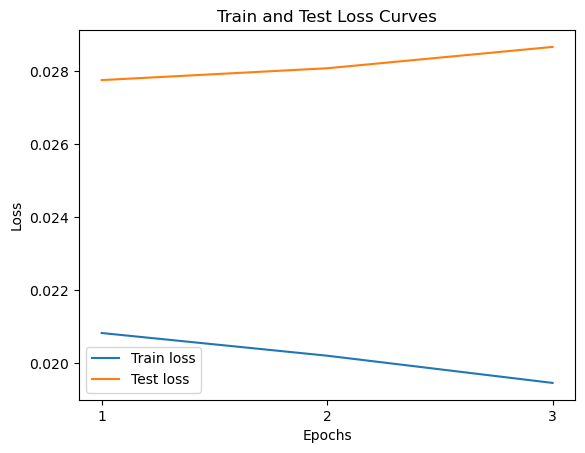

In [20]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()
